# Part 1
 <font size="2">(The document says this part has three questions but I can only find two, second one is from the Preface.)</font>

#### Questions:

**1. Write a regex to extract all the numbers with orange color background from
the text below in italics.**

![](https://github.com/Kanishk-Kumar/hotel_cust_cls/blob/main/json.png?raw=true)

Answer:

In [ ]:
import re

regex = r'(?<=:)\d+'

test_str = "{\"orders\":[{\"id\":1},{\"id\":2},{\"id\":3},{\"id\":4},{\"id\":5},{\"id\":6},{\"id\":7},{\"id\":8},{\"id\":9},{\"id\":10},{\"id\":11},{\"id\":648},{\"id\":649},{\"id\":650},{\"id\":651},{\"id\":652},{\"id\":653}],\"errors\":[{\"code\":3,\"message\":\"[PHP Warning #2] count(): Parameter must be an array or an object that implements Countable (153)\"}]}"

matches = re.finditer(regex, test_str, re.MULTILINE | re.DOTALL)

result = []

for matchNum, match in enumerate(matches, start=1):
    result.append(match.group())

print(result)

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '648', '649', '650', '651', '652', '653', '3']


**2. Why does Google Chrome does not appear in top 3 when you search for browser on playstore?**

Answer:

Probably because it comes pre-installed in Android devices which constitutes the majority of mobile phones and users don't usually need to download it, unlike other mobile web browsers.

# Part 2

## Objective
Train a machine learning model (preferably with a neural network) that
predicts the customer who is going to be checked in.

## EDA And Feature Engineering

Loading all the necessary libraries and data.

In [ ]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

pd.set_option('display.max_columns', None)
pd.options.display.precision = 2

In [ ]:
df = pd.read_csv('https://github.com/Kanishk-Kumar/hotel_cust_cls/blob/main/train.csv?raw=true')
df

,Unnamed: 0,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,0,1,PRT,51.0,150,45,371.00,105.3,1,0,3,8,5,151,1074,Corporate,Corporate,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,2,PRT,NaN,1095,61,280.00,53.0,0,0,1,10,5,1100,1100,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,3,DEU,31.0,1095,0,0.00,0.0,0,0,0,0,0,-1,-1,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,4,FRA,60.0,1095,93,240.00,60.0,0,0,1,10,5,1100,1100,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,5,FRA,51.0,1095,0,0.00,0.0,0,0,0,0,0,-1,-1,Travel Agent/Operator,Travel Agent/Operator,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82575,82575,82576,SWE,51.0,12,114,190.08,6.0,0,0,1,6,3,15,15,Travel Agent/Operator,Other,0,0,0,0,0,0,0,1,0,0,0,0,0
82576,82576,82577,SWE,50.0,12,0,0.00,0.0,0,0,0,0,0,-1,-1,Travel Agent/Operator,Other,0,0,0,0,0,0,0,1,0,0,0,0,0
82577,82577,82578,DEU,50.0,12,18,222.00,255.0,0,0,1,3,3,15,15,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
82578,82578,82579,PRT,NaN,12,11,255.00,9.0,0,0,1,3,3,15,15,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82580 entries, 0 to 82579
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            82580 non-null  int64  
 1   ID                    82580 non-null  int64  
 2   Nationality           82580 non-null  object 
 3   Age                   78834 non-null  float64
 4   DaysSinceCreation     82580 non-null  int64  
 5   AverageLeadTime       82580 non-null  int64  
 6   LodgingRevenue        82580 non-null  float64
 7   OtherRevenue          82580 non-null  float64
 8   BookingsCanceled      82580 non-null  int64  
 9   BookingsNoShowed      82580 non-null  int64  
 10  BookingsCheckedIn     82580 non-null  int64  
 11  PersonsNights         82580 non-null  int64  
 12  RoomNights            82580 non-null  int64  
 13  DaysSinceLastStay     82580 non-null  int64  
 14  DaysSinceFirstStay    82580 non-null  int64  
 15  DistributionChannel

There's a column named 'Unnamed: 0' which I thought might be there for a purpose. From the code below you can see it's just an error from the data retrieval side.

In [ ]:
(df['Unnamed: 0'] + 1 == df['ID']).all()

True

So let's drop it along with the ID column.

In [ ]:
df.drop(['Unnamed: 0', 'ID'], axis = 1, inplace = True)

In [ ]:
df.isnull().sum()

Nationality                0
Age                     3746
DaysSinceCreation          0
AverageLeadTime            0
LodgingRevenue             0
OtherRevenue               0
BookingsCanceled           0
BookingsNoShowed           0
BookingsCheckedIn          0
PersonsNights              0
RoomNights                 0
DaysSinceLastStay          0
DaysSinceFirstStay         0
DistributionChannel        0
MarketSegment              0
SRHighFloor                0
SRLowFloor                 0
SRAccessibleRoom           0
SRMediumFloor              0
SRBathtub                  0
SRShower                   0
SRCrib                     0
SRKingSizeBed              0
SRTwinBed                  0
SRNearElevator             0
SRAwayFromElevator         0
SRNoAlcoholInMiniBar       0
SRQuietRoom                0
dtype: int64

Only age has null values. Let's fill those with the mean age of customers.

In [ ]:
df['Age'] = df['Age'].fillna(df['Age'].mean())

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,82580.0,4.55e+01,16.15,-11.0,34.0,45.47,56.0,122.00
DaysSinceCreation,82580.0,4.59e+02,311.31,12.0,183.0,406.00,728.0,1095.00
AverageLeadTime,82580.0,6.66e+01,87.93,-1.0,0.0,30.00,104.0,588.00
LodgingRevenue,82580.0,3.00e+02,373.34,0.0,66.4,234.00,403.8,21781.00
OtherRevenue,82580.0,6.79e+01,114.50,0.0,2.0,39.00,88.0,7730.25
BookingsCanceled,82580.0,2.05e-03,0.07,0.0,0.0,0.00,0.0,9.00
BookingsNoShowed,82580.0,6.42e-04,0.03,0.0,0.0,0.00,0.0,3.00
BookingsCheckedIn,82580.0,7.98e-01,0.70,0.0,1.0,1.00,1.0,66.00
PersonsNights,82580.0,4.67e+00,4.56,0.0,1.0,4.00,7.0,116.00
RoomNights,82580.0,2.37e+00,2.28,0.0,1.0,2.00,4.0,185.00


We see some negative values in the 'min' column above that don't make sense. Let's make sure minimum values are zeros only.

In [ ]:
num_col = df.select_dtypes(exclude = object).columns
df[df[num_col] < 0] = np.nan
df.fillna(0, inplace = True)

Let's make sure all columns have only one data type.

In [ ]:
(df.applymap(type).apply(pd.value_counts).fillna(0).nunique() - 1).all() == 1

True

Not seeing much correlation between BookingsCheckedin and the three string data type columns in the correlation matrix below

In [ ]:
df.select_dtypes(include=['object']).nunique()

Nationality            188
DistributionChannel      4
MarketSegment            7
dtype: int64

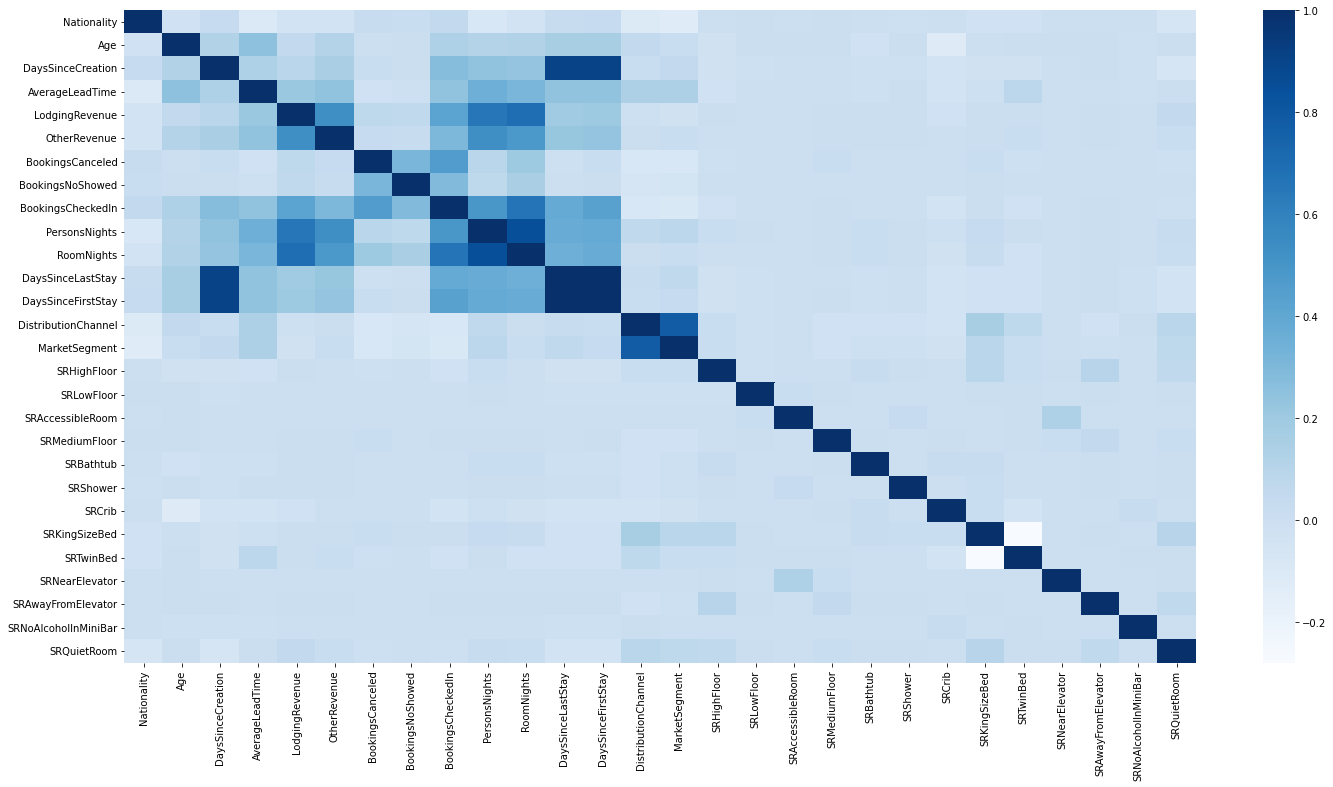

In [ ]:
df['Nationality']  =df['Nationality'].astype('category').cat.codes
df['DistributionChannel'] = df['DistributionChannel'].astype('category').cat.codes
df['MarketSegment'] = df['MarketSegment'].astype('category').cat.codes
plt.figure(figsize = (24, 12))
sns.heatmap(df.corr().round(2), annot = None, cmap = 'Blues')
plt.show()

Since these aren't having any effect on our training results anyway, let's drop them.

In [ ]:
df.drop(['Nationality', 'DistributionChannel', 'MarketSegment'], axis = 1, inplace = True)

Making sure our test set shows customers either checked in or didn't.

In [ ]:
df.loc[df['BookingsCheckedIn'] > 1, 'BookingsCheckedIn'] = 1

In [ ]:
df.skew().sort_values(ascending=False)

SRNoAlcoholInMiniBar    90.86
SRAccessibleRoom        62.69
BookingsCanceled        57.95
SRNearElevator          57.45
BookingsNoShowed        54.80
SRMediumFloor           33.59
SRLowFloor              26.40
SRShower                23.97
SRBathtub               18.79
SRAwayFromElevator      16.70
RoomNights              11.31
OtherRevenue            10.87
SRCrib                   8.66
LodgingRevenue           6.60
SRHighFloor              4.25
SRQuietRoom              2.91
SRTwinBed                2.04
PersonsNights            1.94
AverageLeadTime          1.91
SRKingSizeBed            0.62
DaysSinceCreation        0.39
DaysSinceLastStay        0.29
DaysSinceFirstStay       0.28
Age                     -0.16
BookingsCheckedIn       -1.25
dtype: float64

Columns beginning with the letters SR are too skewed and also have very low correlation but dropping them is only reducing our training accuracy.

In [ ]:
#df.drop(['SRHighFloor', 'SRLowFloor', 'SRAccessibleRoom', 'SRMediumFloor', 'SRBathtub', 'SRShower', 'SRCrib', 'SRKingSizeBed', 'SRTwinBed', 'SRNearElevator', 'SRAwayFromElevator', 'SRNoAlcoholInMiniBar', 'SRQuietRoom'], axis = 1, inplace = True)

In [ ]:
skew_columns = (df.skew().sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
skew_columns

SRNoAlcoholInMiniBar    90.86
SRAccessibleRoom        62.69
BookingsCanceled        57.95
SRNearElevator          57.45
BookingsNoShowed        54.80
SRMediumFloor           33.59
SRLowFloor              26.40
SRShower                23.97
SRBathtub               18.79
SRAwayFromElevator      16.70
RoomNights              11.31
OtherRevenue            10.87
SRCrib                   8.66
LodgingRevenue           6.60
SRHighFloor              4.25
SRQuietRoom              2.91
SRTwinBed                2.04
PersonsNights            1.94
AverageLeadTime          1.91
dtype: float64

In [ ]:
# Won't be performing log transform on skewed columns.
#for col in skew_columns.index.tolist():
#    df[col] = np.log1p(df[col])
#df.skew().sort_values(ascending=False)

In [ ]:
# Min-max scaling. This is also not needed.
#checkins = df.BookingsCheckedIn
#df_norm = df.drop('BookingsCheckedIn', axis=1, inplace = True)
#df_norm = (df-df.min())/(df.max()-df.min())
#df = pd.concat((df_norm, checkins), axis = 1)

In [ ]:
feature_cols = df.columns[df.columns != 'BookingsCheckedIn']

# Getting the split indexes.
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.2, 
                                          random_state=21)

train_idx, test_idx = next(strat_shuf_split.split(df[feature_cols], df.BookingsCheckedIn))

# Creating the dataframes.

X_train = df.loc[train_idx, feature_cols].astype(float)
y_train = df.loc[train_idx, 'BookingsCheckedIn'].astype(float)

X_test  = df.loc[test_idx, feature_cols].astype(float)
y_test  = df.loc[test_idx, 'BookingsCheckedIn'].astype(float)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(66064, 24) (66064,)
(16516, 24) (16516,)


In [ ]:
# Standard scaling is not having any positive effect.
#scaler = StandardScaler()

#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

In [ ]:
# Unique value counts in our target training data.
unique, counts = np.unique(y_train, return_counts=True)
result = np.column_stack((unique, counts)).astype(int)
print(result)

[[    0 15515]
 [    1 50549]]


## Modeling

Labels that are useful in plotting confusion matrix.

In [ ]:
labels = ['Will Checkin', 'Won\'t Checkin']

Function to plot the confusion matrix.

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Functions to run specified model.

In [ ]:
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=False, cm_cmap=plt.cm.Blues):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('\nAccuracy: {}\n'.format(round(accuracy, 2)))
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm:
        print('Confusion Matrix:')
        print('{}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(visible=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=False, title='Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('Classifiction Report:')
    classification_report = metrics.classification_report(y_test, y_pred)
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results

def perform_deep_model(model, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=False, cm_cmap=plt.cm.Blues):
    
    # to store results at various phases
    results = dict()
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    
    y_pred = model_net.predict(X_test)
    y_pred = tf.greater(y_pred, .5)
    
    test_end_time = datetime.now()
    print('Done')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('\nAccuracy: {}\n'.format(round(accuracy, 2)))
    print('')
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm:
        print('Confusion Matrix:')
        print('{}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(visible=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=False, title='Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('Classifiction Report:')
    classification_report = metrics.classification_report(y_test, y_pred, labels=np.unique(y_pred))
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    #return results

Method to print the gridsearch attributes.

In [ ]:
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('Best Estimator: {}'.format(model.best_estimator_))
    # parameters that gave best results while performing grid search
    print('Best parameters: Parameters of best estimator : {}'.format(model.best_params_))
    #  number of cross validation splits
    print('No of CrossValidation Sets: Total number of cross validation sets: {}'.format(model.n_splits_))
    # Average cross validated score of the best estimator, from the Grid Search 
    print('Average cross validated score of the best estimators: {}'.format(model.best_score_))

### 1. LinearSVC

training the model..
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Done
training_time(HH:MM:SS.ms) - 0:00:11.919312
Predicting test data
Done
testing time(HH:MM:SS:ms) - 0:00:00.021733

Accuracy: 1.0



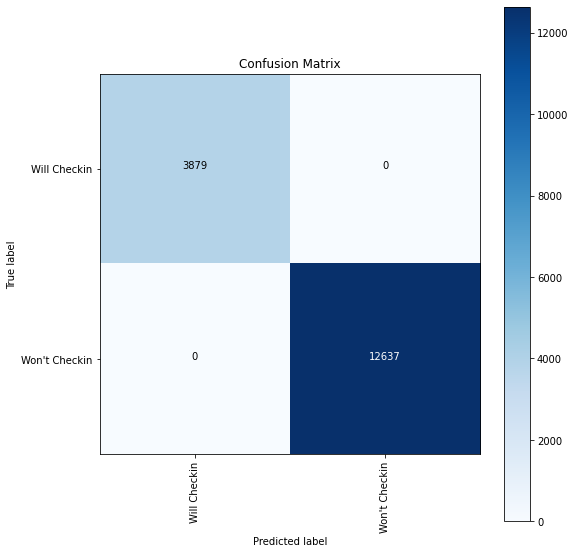

Classifiction Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3879
         1.0       1.00      1.00      1.00     12637

    accuracy                           1.00     16516
   macro avg       1.00      1.00      1.00     16516
weighted avg       1.00      1.00      1.00     16516

Best Estimator: LinearSVC(C=0.125, random_state=21, tol=5e-05)
Best parameters: Parameters of best estimator : {'C': 0.125}
No of CrossValidation Sets: Total number of cross validation sets: 5
Average cross validated score of the best estimators: 0.9999848633921138


In [ ]:
parameters = {'C':[0.125, 0.5, 1, 2, 8, 16]}
lr_svc = LinearSVC(tol=0.00005, max_iter=1000, random_state = 21)
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=-1, verbose=1)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(lr_svc_grid_results['model'])

In [ ]:
model_svc = LinearSVC(C = 0.125, tol = 5e-05, random_state = 21)
model_svc.fit(X_train, y_train)

LinearSVC(C=0.125, random_state=21, tol=5e-05)

### 2. Decision Tree

training the model..
Done
training_time(HH:MM:SS.ms) - 0:00:02.394154
Predicting test data
Done
testing time(HH:MM:SS:ms) - 0:00:00.005468

Accuracy: 1.0



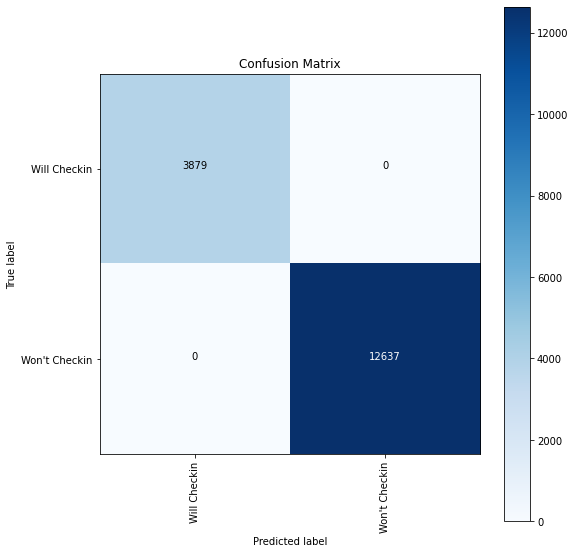

Classifiction Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3879
         1.0       1.00      1.00      1.00     12637

    accuracy                           1.00     16516
   macro avg       1.00      1.00      1.00     16516
weighted avg       1.00      1.00      1.00     16516

Best Estimator: DecisionTreeClassifier(max_depth=3, random_state=21)
Best parameters: Parameters of best estimator : {'max_depth': 3}
No of CrossValidation Sets: Total number of cross validation sets: 5
Average cross validated score of the best estimators: 0.9999848622464427


In [ ]:
parameters = {'max_depth':np.arange(3,10,2)}
dt = DecisionTreeClassifier(random_state = 21)
dt_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=-1)
dt_grid_results = perform_model(dt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(dt_grid_results['model'])

In [ ]:
model_tree = DecisionTreeClassifier(max_depth=3, random_state = 21)
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=21)

### 3. Neural Net

In [ ]:
model_net = Sequential()

model_net.add(Dense(12, activation = 'sigmoid', input_dim = 24))
model_net.add(Dense(1, activation = 'sigmoid'))

model_net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                300       
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 313
Trainable params: 313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# time at which model starts training 
train_start_time = datetime.now()
print('training the model..')

model_net.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 8
batch_size = 64


run_hist = model_net.fit(X_train, y_train,
                      batch_size = batch_size, 
                      epochs = epochs, verbose = 1, 
                      validation_split = 0.2)

print('Done')
train_end_time = datetime.now()
time = dict()
time['training_time'] =  train_end_time - train_start_time
print('training_time(HH:MM:SS.ms) - {}'.format(time['training_time']))

training the model..
Epoch 1/8
826/826 [==============================] - 6s 6ms/step - loss: 0.1861 - accuracy: 0.9448 - val_loss: 0.0487 - val_accuracy: 1.0000
Epoch 2/8
826/826 [==============================] - 5s 6ms/step - loss: 0.0272 - accuracy: 1.0000 - val_loss: 0.0157 - val_accuracy: 1.0000
Epoch 3/8
826/826 [==============================] - 6s 8ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 4/8
826/826 [==============================] - 5s 6ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 0.0041 - val_accuracy: 1.0000
Epoch 5/8
826/826 [==============================] - 5s 6ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 6/8
826/826 [==============================] - 4s 5ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/8
826/826 [==============================] - 3s 4ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 9.6578e-04 - val_accur

Predicting test data
517/517 [==============================] - 1s 1ms/step
Done
testing time(HH:MM:SS:ms) - 0:00:00.923124

Accuracy: 1.0




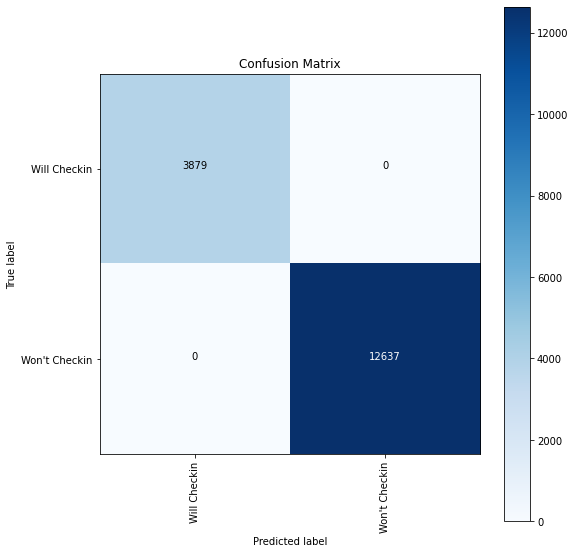

Classifiction Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      3879
        True       1.00      1.00      1.00     12637

    accuracy                           1.00     16516
   macro avg       1.00      1.00      1.00     16516
weighted avg       1.00      1.00      1.00     16516



In [ ]:
perform_deep_model(model_net, X_test, y_test, class_labels = labels)

In [ ]:
y_pred = model_net.predict(X_test)
y_pred = tf.greater(y_pred, .5)

517/517 [==============================] - 1s 1ms/step


### Comparing All Models
<hr>

In [ ]:
print('\n                     Accuracy     Error')
print('                     ----------   --------')

print('Linear SVC          : {:.04}%       {:.04}% '.format(lr_svc_grid_results['accuracy'] * 100,\
                                                        100-(lr_svc_grid_results['accuracy'] * 100)))

print('DecisionTree        : {:.04}%       {:.04}% '.format(dt_grid_results['accuracy'] * 100,\
                                                        100-(dt_grid_results['accuracy'] * 100)))

print('Deep Learning       : {:.04}%       {:.04}% '.format(metrics.accuracy_score(y_true=y_test, y_pred=y_pred) * 100,\
                                                        100-(metrics.accuracy_score(y_true=y_test, y_pred=y_pred) * 100)))

print('\n')


                     Accuracy     Error
                     ----------   --------
Linear SVC          : 100.0%       0.0% 
DecisionTree        : 100.0%       0.0% 
Deep Learning       : 100.0%       0.0% 




## Testing

Functions to test model and clean data.

In [ ]:
def test_model(model, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=False, cm_cmap=plt.cm.Blues):
        
    # to store results at various phases
    results = dict()
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('\nAccuracy: {}\n'.format(round(accuracy, 2)))
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm:
        print('Confusion Matrix:')
        print('{}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(visible=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=False, title='Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('Classifiction Report:')
    classification_report = metrics.classification_report(y_test, y_pred, labels = np.unique(y_pred))
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    #return results

def test_deep_model(model, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=False, cm_cmap=plt.cm.Blues):
    
    
    # to store results at various phases
    results = dict()
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    
    y_pred = model_net.predict(X_test)
    y_pred = tf.greater(y_pred, .5)
    
    test_end_time = datetime.now()
    print('Done')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('\nAccuracy: {}\n'.format(round(accuracy, 2)))
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm:
        print('Confusion Matrix:')
        print('{}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8,8))
    plt.grid(visible=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=False, title='Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('Classifiction Report:')
    classification_report = metrics.classification_report(y_test, y_pred, labels=np.unique(y_pred))
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    #return results

def clean(df):
    df.drop(['Unnamed: 0', 'ID'], axis = 1, inplace = True)
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    num_col = df.select_dtypes(exclude = object).columns
    df.drop(['Nationality', 'DistributionChannel', 'MarketSegment'], axis = 1, inplace = True)
    df[df[num_col] < 0] = np.nan
    df.fillna(0, inplace = True)
    df.loc[df['BookingsCheckedIn'] > 1, 'BookingsCheckedIn'] = 1
    skew_columns = (df.skew().sort_values(ascending=False))
    skew_columns = skew_columns.loc[skew_columns > 0.75]
    X_test = df.drop(['BookingsCheckedIn'], axis = 1)
    print('Final shape of test data: {}'.format(X_test.shape))
    y_test = df['BookingsCheckedIn']
    return X_test, y_test

In [ ]:
df = pd.read_csv('https://github.com/Kanishk-Kumar/hotel_cust_cls/blob/main/test.csv?raw=true')
df.head(3)

,Unnamed: 0,ID,Nationality,Age,DaysSinceCreation,AverageLeadTime,LodgingRevenue,OtherRevenue,BookingsCanceled,BookingsNoShowed,BookingsCheckedIn,PersonsNights,RoomNights,DaysSinceLastStay,DaysSinceFirstStay,DistributionChannel,MarketSegment,SRHighFloor,SRLowFloor,SRAccessibleRoom,SRMediumFloor,SRBathtub,SRShower,SRCrib,SRKingSizeBed,SRTwinBed,SRNearElevator,SRAwayFromElevator,SRNoAlcoholInMiniBar,SRQuietRoom
0,82590,82591,SGP,47.0,11,0,0.00,0.0,0,0,0,0,0,-1,-1,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
1,82591,82592,SGP,16.0,11,130,483.48,155.1,0,0,1,15,5,16,16,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0
2,82592,82593,SGP,15.0,11,0,0.00,0.0,0,0,0,0,0,-1,-1,Travel Agent/Operator,Other,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_test, y_test = clean(df)

Final shape of test data: (1000, 24)


### 1. LinearSVC

Predicting test data
Done
testing time(HH:MM:SS:ms) - 0:00:00.008346

Accuracy: 1.0



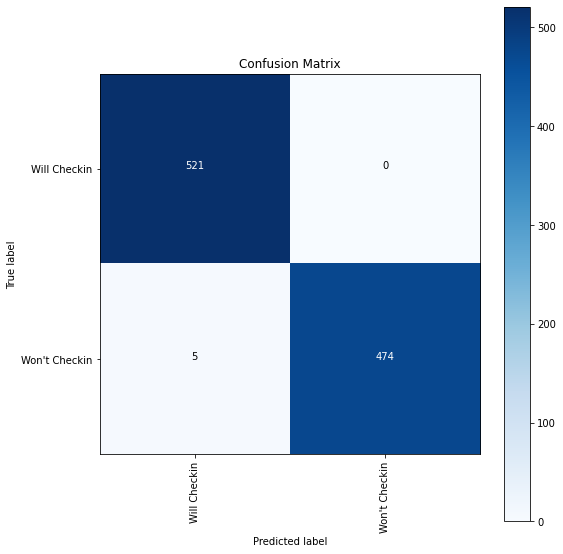

Classifiction Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       521
         1.0       1.00      0.99      0.99       479

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



In [ ]:
test_model(model_svc, X_test, y_test, class_labels = labels)

### 2. Decision Tree

Predicting test data
Done
testing time(HH:MM:SS:ms) - 0:00:00.003929

Accuracy: 1.0



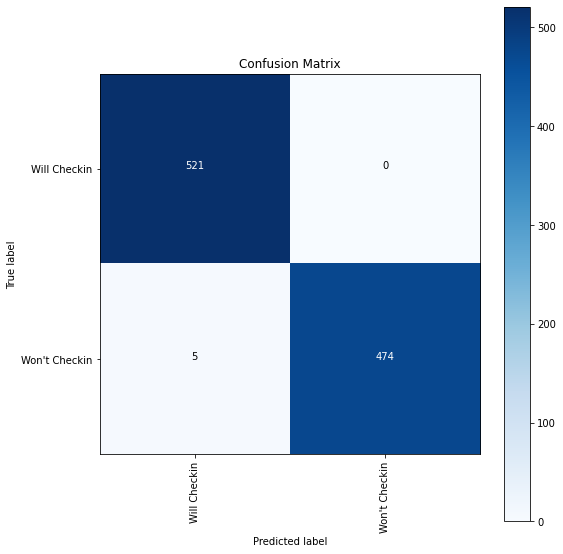

Classifiction Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       521
         1.0       1.00      0.99      0.99       479

    accuracy                           0.99      1000
   macro avg       1.00      0.99      0.99      1000
weighted avg       1.00      0.99      0.99      1000



In [ ]:
test_model(model_tree, X_test, y_test, class_labels = labels)

### 3. Neural Net

Predicting test data
32/32 [==============================] - 0s 1ms/step
Done
testing time(HH:MM:SS:ms) - 0:00:00.111894

Accuracy: 1.0



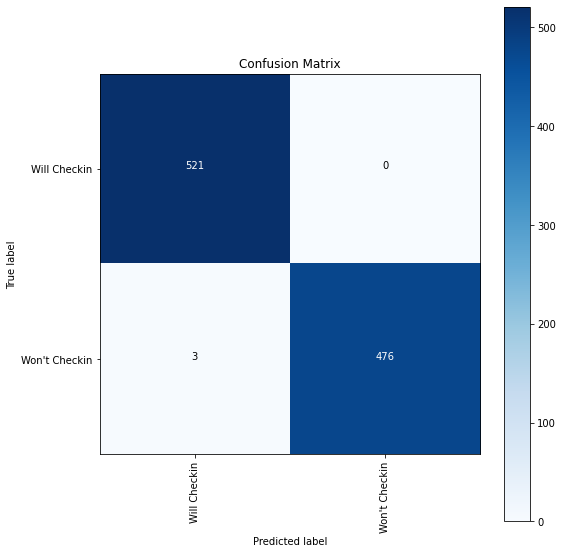

Classifiction Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00       521
        True       1.00      0.99      1.00       479

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [ ]:
test_deep_model(model_net, X_test, y_test, class_labels = labels)

In [ ]:
# Saving our models.
#import pickle

#pickle.dump(model_svc, open('model_svc.pkl', 'wb'))
#pickle.dump(model_tree, open('model_tree.pkl', 'wb'))
#model_net.save('model_net.h5') # Lightweight format as we don't have much complex of a model.

## Conclusion

All three models have performed extremely well on the test dataset.

#### Questions:

**1. Write about any difficult problem that you solved. (According to us difficult - is
something which 90% of people would have only 10% probability in getting a
similarly good solution).**

Answer:

I did a project on time series analysis using Facebook Prophet and forecasted the gas prices of Britain for up to 15 days. I think Prophet library is for some reason not well maintained because I had to create a separate environment with an older Python version just to run it. Many of the codes I found online were deprecated and above all learning the statistics behind how to implement the model was the hardest part. I succeeded with acceptable accuracy. Compared to Prophet, TensorFlow's LSTM models are a black box, but I still ended up using TensorFlow in the end due to high accuracy.

**2. Explain back propagation and tell us how you handle a dataset if 4 out of 30
parameters have null values more than 40 percentage**

Answer:

Back propagation essentially means that after each epoch, the model compares a batch of the predicted data with the real ones, the more the difference, the more the value of the cost function. To reduce that value it adjusts the weights and biases of all the neurons in the previous layer and then repeats the process for the layer before that and keeps repeating down to the very first layer and then continues with the next epoch with the adjusted weights and biases and keeps repeating the whole process until it reaches the local minimum of the cost function.

4 out of 30 parameters having >40% null values isn't that bad. That much missing data is almost always not missing at random, so conducting a separate EDA on those could be very valuable. I'll change the column type to what they're supposed to be and check for their skewness. Further steps depend on a lot of other factors as well.